# Predicting the Genre of Books from Summaries
## Priya Chotalia

In [1]:
import csv
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import linear_model
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build a predictive model to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select a suitable model to classify them. You should build at least one model but you could build two and compare the results if you have time.

You should report on each stage of your experiment as you work with the data.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"": ""Satire"", ""/m/0dwly"": ""Children's literature"", ""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf"": ""Fiction""}","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""Novella"", ""/m/014dfn"": ""Speculative fiction"", ""/m/0c082"": ""Utopian and dystopian fiction"", ""/m/06nbt"": ""Satire"", ""/m/02xlf"": ""Fiction""}","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fiction"", ""/m/0pym5"": ""Absurdist fiction"", ""/m/05hgj"": ""Novel""}","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,"The argument of the Enquiry proceeds by a series of incremental steps, separated into chapters which logically succeed one another. After expounding his epistemology, Hume explains how to apply his principles to specific topics. In the first section of the Enquiry, Hume provides a rough introdu..."
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""Speculative fiction"", ""/m/01hmnh"": ""Fantasy"", ""/m/02xlf"": ""Fiction""}","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape

(8954, 5)

In [4]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Modelling
* Adding a new column **Title + Author** which will merge title and author of the books in our dataset which will help us to predict the genre of a particular book based on the title and author of the book.


In [5]:
genre_books['title + author'] = pd.DataFrame(genre_books['title'] + ' ' + genre_books['author'])
print (genre_books['title + author'].head(5))

0                 Animal Farm George Orwell
1        A Clockwork Orange Anthony Burgess
2                   The Plague Albert Camus
4         A Fire Upon the Deep Vernor Vinge
6    A Wizard of Earthsea Ursula K. Le Guin
Name: title + author, dtype: object


* First step is to clean the dataset. Removing all the stop words such as *i, me, myself....*

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

genre_books['title + author'] = genre_books['title + author'].apply(lambda x: remove_stopwords(x))

stop = list(stopwords.words('english'))
stop[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

* Using **unique function** to get the unique number for each genre which will make it easier for prediction.

In [7]:
genre_books['genre'].unique()

array(["Children's literature", 'Novel', 'Fantasy', 'Science Fiction',
       'Mystery'], dtype=object)

### Label Encoding
* Label encoder will convert the labels (genre) into numeric form (0, 1, 2, 3, 4)

In [8]:
from sklearn.preprocessing import LabelEncoder
feat = ['genre']
for x in feat:
    le = LabelEncoder()
    le.fit(list(genre_books[x].values))
    genre_books[x] = le.transform(list(genre_books[x]))

In [9]:
genre_books['genre'].unique()

array([0, 3, 1, 4, 2], dtype=int64)

* As we can see the **unique ID** for genre **Childer's literature** is **0**, for **Fantasy** is **1**, for **Mystery** is **2** and similary for **Novel** is **3** and **Science fiction** is **4**.

In [10]:
print(le.inverse_transform([0])[0])
print(le.inverse_transform([1])[0])
print(le.inverse_transform([2])[0])
print(le.inverse_transform([3])[0])
print(le.inverse_transform([4])[0])

Children's literature
Fantasy
Mystery
Novel
Science Fiction


In [11]:
def change(t):
    t = t.split()
    return ' '.join([(i) for (i) in t if i not in stop])

### TfidfVectorizer
* Tfidf (Term Frequency – Inverse Document) Vectorizer will Convert a collection of raw documents to a matrix of TF-IDF features.
* TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

In [12]:
vectorizer = TfidfVectorizer(min_df=2, max_features=70000, strip_accents='unicode', lowercase =True, analyzer='word', token_pattern=r'\w+', use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = 'english')
vectors = vectorizer.fit_transform(genre_books['title + author'])

* Splitting the dataset into train and test data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(vectors, genre_books['genre'], test_size=0.02)

In [14]:
type(genre_books)

pandas.core.frame.DataFrame

#### Here, Multinomial Naive Bayes classifier and Logistic Regression are used and based on the accuracy score, we will decide which model to use for prediction.

###  Multinomial Naive Bayes classifier
We can use Multinomial Naive Bayes classifier as it is suitable for classification with discrete features (e.g., word counts for text classification). Here wehave to predict the genre based on title and author's name. 

In [17]:
clf = MultinomialNB(alpha=.45)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.5532923028366277
0.5555555555555556


### Logistic Regression

In [18]:
clf = linear_model.LogisticRegression(solver= 'sag',max_iter=200,random_state=450)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.5853109557676143
0.5888888888888889


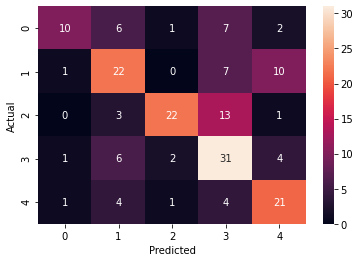

In [19]:
confusion_matrix = pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')

The accuracy score of **Logistic Regression model** is **higher** as compared to that of **MultinomialNB model**. So we will use Logistic Regression model for our prediction.

In [20]:
genre_books.head()

,title,author,date,summary,genre,title + author
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p...",0,Animal Farm George Orwell
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and...",3,A Clockwork Orange Anthony Burgess
2,The Plague,Albert Camus,1947,"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t...",3,The Plague Albert Camus
4,A Fire Upon the Deep,Vernor Vinge,,"The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti...",1,A Fire Upon Deep Vernor Vinge
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger islands in the north of the archipelago of Earthsea. His mother is dead, his much older siblings have all left home, and his father is a dour, taciturn bronzesmith with nothing in common with his son, so the boy grows up wild and headstrong. Ged dis...",1,A Wizard Earthsea Ursula K. Le Guin


* Predicting the genre of the book **Animal Farm**. 

In [21]:
text = ['Animal Farm']
text[0] = text[0].lower()
s = (vectorizer.transform(text))
d = (clf.predict(s))
le.inverse_transform(d)[0]

"Children's literature"

* The model has predicted the genre of the book **Animal Farm** correctly. 
* We can see the unique ID given to different genre above and check if the model has predicted the genre correctly or not.

In [22]:
text = ['A Fire Upon the Deep']
text[0] = text[0].lower()
#text = list(text)
s = (vectorizer.transform(text))
#s = vectorizer.fit_transform(df)
d = (clf.predict(s))
le.inverse_transform(d)[0]

'Fantasy'

* The model has not predicted the genre of the book **Dracula** correctly. The original genre of that book is **Mystery**.

In [23]:
text = ['Dracula']
text[0] = text[0].lower()
#text = list(text)
s = (vectorizer.transform(text))
#s = vectorizer.fit_transform(df)
d = (clf.predict(s))
le.inverse_transform(d)[0]

'Novel'

In [24]:
text = ['Death Comes to Pemberley']
text[0] = text[0].lower()
#text = list(text)
s = (vectorizer.transform(text))
#s = vectorizer.fit_transform(df)
d = (clf.predict(s))
le.inverse_transform(d)[0]

'Mystery'

In [25]:
text = ['Blade Runner 2: The Edge of Human']
text[0] = text[0].lower()
#text = list(text)
s = (vectorizer.transform(text))
#s = vectorizer.fit_transform(df)
d = (clf.predict(s))
le.inverse_transform(d)[0]

'Science Fiction'

In [26]:
text = ['Crash']
text[0] = text[0].lower()
#text = list(text)
s = (vectorizer.transform(text))
#s = vectorizer.fit_transform(df)
d = (clf.predict(s))
le.inverse_transform(d)[0]

'Novel'

## Observation
* The logistic regression model cannot predict the genre's 100% correctly as the accuray of the model is 0.67. 